# Weighted Histogram Analysis Method (WHAM) for free energy calculations.

In [18]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [19]:
def flat(x_vals):
    return np.zeros_like(x_vals)

def w_shape(x_vals):
    return x_vals**4 - 0.85*x_vals**2

def barrier(x_vals):
    return 100*x_vals**4 - 100*x_vals**2

class Dynamics():
    def __init__(self, fes_func):

        self.x_vals = np.linspace(-1,1,100)
        self.bin_width = self.x_vals[1] - self.x_vals[0]
        self.fes_func = fes_func
        self.underlying_fes = fes_func(self.x_vals)
        
        self.boltz_weights = np.exp(-self.underlying_fes)

        self.underlying_prob_dist = self.boltz_weights / (np.sum(self.boltz_weights)*self.bin_width)

    def dynamics(self,nsteps):
        x_index = np.random.randint(0,len(self.x_vals))
        # x_index = np.where(self.underlying_fes == self.underlying_fes.min())[0][0]
        coord = self.x_vals[x_index]
        self.time = [0]
        self.trajectory = [coord]
        num_acceptances = 0

        for i in range(nsteps):
            rand = np.random.rand()
            self.time.append(i+1)
            
            if rand >= 0.5:
                # Impose PBC
                if (x_index + 1) == 100:
                    trial_index = 0

                else:
                    trial_index = x_index + 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            else:
                # Impose PBC
                if (x_index - 1) == -1:
                    trial_index = 99

                else:
                    trial_index = x_index - 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            coord = self.x_vals[x_index]
            
            self.trajectory.append(coord)
        
        self.acceptance_prob = num_acceptances / nsteps

    def calc_unbiased_prob(self):
        hist, _ = np.histogram(self.trajectory,range=(-1,1),bins=100)

        self.prob_hist = hist/(hist.sum()*self.bin_width)
        weights = np.exp(self.bias,dtype='float128')
        self.unbiased_prob = self.prob_hist*weights

class Umbrella_sampling():
    def __init__(self,numbrellas,kappa,fes_func):

        self.numbrellas = numbrellas
        self.centers = np.linspace(-1,1,numbrellas)
        self.replicas = []
        for i in range(numbrellas):
            replica_window = Dynamics(fes_func)
            replica_window.bias = self.harmonic_restraint((replica_window.x_vals),(self.centers[i]),kappa)
            replica_window.underlying_fes += replica_window.bias
            replica_window.boltz_weights = np.exp(-replica_window.underlying_fes)
            replica_window.underlying_prob_dist = replica_window.boltz_weights / (np.sum(replica_window.boltz_weights)*replica_window.bin_width)
            self.replicas.append(copy.deepcopy(replica_window))

    def dynamics(self,nsteps):
        self.nsteps = nsteps
        for i in range(self.numbrellas):
            self.replicas[i].dynamics(nsteps)
        
    
    def harmonic_restraint(self,x_vals,center,kappa):
        return 0.5 * kappa * (x_vals - center)**2
    
class WHAM():
    def __init__(self,umb_sim,iterations,beta=1):

        self.umb_sim = umb_sim
        self.F = np.ones(umb_sim.numbrellas)
        print(f'F = {self.F.shape}')
        self.omega = np.array([umb_sim.replicas[i].bias for i in range(umb_sim.numbrellas)])
        print(f'omega = {self.omega.shape}')
        Pi_biased = []
        Pi_unbiased = []
        for window in umb_sim.replicas:
            window.calc_unbiased_prob()
            Pi_biased.append(window.prob_hist)
            Pi_unbiased.append(window.unbiased_prob)
        self.Pi_biased = np.array(Pi_biased)
        print(f'Pi_biased = {self.Pi_biased.shape}')
        self.Pi_unbiased = np.array(Pi_unbiased)
        print(f'Pi_unbiased = {self.Pi_unbiased.shape}')

        for i in range(iterations):
            self.a = self.calc_a(umb_sim.nsteps,self.omega,self.F)
            if i == 0:
                print(f'a = {self.a.shape}')
            self.weights = self.calc_weights(self.a)
            if i == 0:
                print(f'weights = {self.weights.shape}')
            self.P_unbiased = self.calc_P_unbiased(self.weights,self.Pi_unbiased)
            if i == 0:
                print(f'P_unbiased = {self.P_unbiased.shape}')
            self.F = self.calc_F(self.P_unbiased,self.omega)
            if i == 0 :
                print(f'F = {self.F.shape}')


        self.Gi = self.calc_Gi(self.Pi_biased,self.omega,self.F)
        print(f'Gi = {self.Gi.shape}')

        prob_i = np.exp(-self.Gi*beta)
        print(f'prob_i = {prob_i.shape}')
        self.P = np.sum(prob_i,axis=0) / (np.sum(prob_i)*umb_sim.replicas[0].bin_width)
        print(f'P = {self.P.shape}')
        self.G = -(1/beta)*np.log(self.P)
        print(f'G = {self.G.shape}')
    
    def calc_F(self,P_unbiased,omega,beta=1):
        return -np.log(np.sum(P_unbiased*np.exp(-beta*omega)*self.umb_sim.replicas[0].bin_width,axis=1)) / beta
    
    def calc_P_unbiased(self,weights,Pi_unbiased):
        return np.sum(weights*Pi_unbiased,axis=0)
    
    def calc_weights(self,a):
        return a / np.sum(a,axis=0)
    
    def calc_a(self,N,omega,F,beta=1):
        return (N*np.exp(-beta*omega.T + beta*F)).T
    
    def calc_Gi(self,biased_prob,omega,F,beta=1):
        return -(1/beta)*np.log(biased_prob) - (omega.T + F).T




In [20]:
umb = Umbrella_sampling(30,500,barrier)
umb.dynamics(100000)

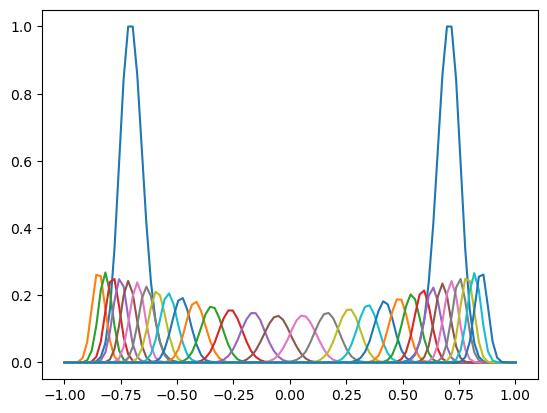

In [21]:
x_vals = umb.replicas[0].x_vals
fes = barrier(x_vals)
fes = fes - fes.min()
fes = barrier(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
plt.plot(x_vals, prob_dist)

for i in range(umb.numbrellas):
    hist, _ = np.histogram(umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/hist.sum()
    plt.plot(x_vals,hist)

In [22]:
wham = WHAM(umb,100000)

F = (30,)
omega = (30, 100)
Pi_biased = (30, 100)
Pi_unbiased = (30, 100)
a = (30, 100)
weights = (30, 100)
P_unbiased = (100,)
F = (30,)
Gi = (30, 100)
prob_i = (30, 100)
P = (100,)
G = (100,)


/tmp/ipykernel_133296/898420207.py:153: RuntimeWarning: divide by zero encountered in log
  return -(1/beta)*np.log(biased_prob) - (omega.T + F).T
/tmp/ipykernel_133296/898420207.py:137: RuntimeWarning: divide by zero encountered in log
  self.G = -(1/beta)*np.log(self.P)


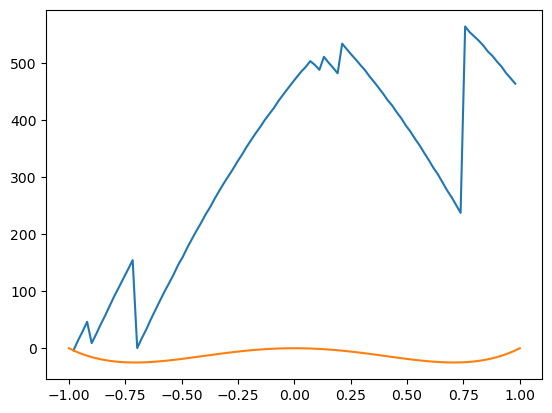

In [23]:
x_vals = umb.replicas[0].x_vals
fes = barrier(x_vals)
plt.plot(x_vals,wham.G)
plt.plot(x_vals,fes)

In [ ]:
dyn = Dynamics(barrier)
dyn.dynamics(10000000)

print(dyn.acceptance_prob)
plt.plot(dyn.time,dyn.trajectory)
plt.ylim(-1,1)


In [ ]:
hist, _ = np.histogram(dyn.trajectory,range=(-1,1),bins=100)

prob_hist = hist/hist.sum()

plt.plot(dyn.x_vals,dyn.underlying_prob_dist,label='Underlying Probability Distribution')
plt.plot(dyn.x_vals,prob_hist,label='Probability Distribution from Dynamics')
plt.legend()

In [ ]:
sampled_fes = -np.log(prob_hist)
plt.plot(dyn.x_vals,dyn.underlying_fes-dyn.underlying_fes.min())
plt.plot(dyn.x_vals,sampled_fes-sampled_fes.min())